# The loss function (loghazard) has issues, so we need to look into that.

**For now it might be good to use pytorch.loss**, which implements partial log liklihood and Weibull losses. 

---

### **Context: Why Breslow’s Method?**

In the Cox model, the **partial likelihood** is used to estimate the regression coefficients without specifying the baseline hazard function. However, when **ties** occur — that is, **multiple events happen at the same time point** — the original Cox partial likelihood (which assumes distinct event times) becomes problematic.

This is where **Breslow’s method** comes in: it provides a way to **approximate the partial likelihood** in the presence of tied event times.

---

### **Breslow’s Approximation: The Idea**

Suppose at time \( t_j \), **\( d_j \) individuals** experience the event (i.e., a tie). Let:

- \( R_j \): the **risk set** just before time \( t_j \)
- \( \beta \): the vector of regression coefficients
- \( x_i \): covariate vector for individual \( i \)

The **exact partial likelihood** for tied events is computationally intensive. Breslow proposed a simpler approximation:

\[
L_B(\beta) = \prod_{j} \frac{\exp\left( \sum_{i \in D_j} \beta^T x_i \right)}{\left[ \sum_{i \in R_j} \exp(\beta^T x_i) \right]^{d_j}}
\]

Where:
- \( D_j \): the set of individuals who fail at time \( t_j \)
- The denominator is raised to the power \( d_j \), treating the tied events as if they occurred **sequentially but with the same risk set**.

---

### **Interpretation**

- **Numerator**: Product of exponentiated linear predictors for those who failed at \( t_j \)
- **Denominator**: Risk set sum raised to the number of events — this is the **approximation** part

This method **underestimates the denominator** slightly compared to the exact method, especially when the number of ties is large.

---

### **Comparison with Other Methods**

| Method         | Accuracy with Ties | Computational Cost | Notes |
|----------------|--------------------|--------------------|-------|
| **Breslow**    | Low (for many ties) | Low                | Simple, fast |
| **Efron**      | Higher              | Moderate           | Better approximation |
| **Exact**      | Highest             | High               | Computationally expensive |

---

### **When to Use Breslow’s Method**

- **Few ties**: Breslow is often sufficient and computationally efficient.
- **Many ties**: Prefer **Efron’s method** or **exact partial likelihood**.

---



In [ ]:
import torchsurv.loss.cox as tscox #import neg_partial_log_likelihood

# Own implementation (super simple, double check!). Assumes events are ordered already.

def naive_partial_likelihood(log_hazard, event_indicator, event_time):
    risk_set = torch.flip(torch.cumsum(torch.flip(torch.exp(log_hazard), [0]), dim=0), [0])
    partial_likelihood = torch.sum(log_hazard[event_indicator == 1] - torch.log(risk_set[event_indicator == 1]))
    return partial_likelihood

def breslow_partial_likelihood(log_hazard, event_indicator, event_time):
    unique_times, counts = torch.unique(event_time[event_indicator == 1], return_counts=True)
    print(unique_times, counts)
    partial_likelihood = 0
    for t, d in zip(unique_times, counts):
        risk_set = torch.sum(torch.exp(log_hazard[event_time >= t]))
        partial_likelihood += torch.sum(log_hazard[(event_time == t) & (event_indicator == 1)]) - d * torch.log(risk_set)
        print(t, d, risk_set)
    return partial_likelihood

def efron_partial_likelihood(log_hazard, event_indicator, event_time):
    unique_times, counts = torch.unique(event_time[event_indicator == 1], return_counts=True)
    partial_likelihood = 0
    for t, d in zip(unique_times, counts):
        risk_set = torch.sum(torch.exp(log_hazard[event_time >= t]))
        tied_hazard_sum = torch.sum(torch.exp(log_hazard[(event_time == t) & (event_indicator == 1)]))
        for k in range(d):
            partial_likelihood += (torch.sum(log_hazard[(event_time == t) & (event_indicator == 1)]) - torch.log(risk_set - k * tied_hazard_sum / d))
    return partial_likelihood

# Example usage
log_hazard = torch.tensor([0.5, 1.0, 1.0, 1.5, 2.0])
event_indicator = torch.tensor([1, 1, 0, 1, 1])
event_time = torch.tensor([1, 2, 2, 2, 3])

log_hazard = torch.tensor([0.5, 1.0, 1.5, 2.0])
event_indicator = torch.tensor([1, 1, 1, 1])
event_time = torch.tensor([1, 2, 2, 3])

reduction = 'mean' # or 'sum', depending on your needs
torchsurv_ll_breslow = tscox.neg_partial_log_likelihood(log_hazard, event_indicator, event_time, ties_method='breslow', reduction = reduction)
torchsurv_ll_efron = tscox.neg_partial_log_likelihood(log_hazard, event_indicator, event_time, ties_method='efron', reduction = reduction)
partial_ll_naive = naive_partial_likelihood(log_hazard, event_indicator, event_time)
partial_ll_breslow = breslow_partial_likelihood(log_hazard, event_indicator, event_time)
partial_ll_efron = efron_partial_likelihood(log_hazard, event_indicator, event_time)

print("---")
print("TorchSurv Breslow Partial Likelihood:", torchsurv_ll_breslow.item())
print("TorchSurv Efron Partial Likelihood:  ", torchsurv_ll_efron.item())
print("---")
print("Naive Partial Likelihood:  ", partial_ll_naive.item())
print("Breslow Partial Likelihood:", partial_ll_breslow.item())
print("Efron Partial Likelihood:  ", partial_ll_efron.item())

tensor([1, 2, 3]) tensor([1, 2, 1])
tensor(1) tensor(1) tensor(16.2377)
tensor(2) tensor(2) tensor(14.5890)
tensor(3) tensor(1) tensor(7.3891)
---
TorchSurv Breslow Partial Likelihood: 1.680269718170166
TorchSurv Efron Partial Likelihood:   1.6215022802352905
---
Naive Partial Likelihood:   -4.941685199737549
Breslow Partial Likelihood: -5.1478776931762695
Efron Partial Likelihood:   -2.364506959915161


C:\Users\ericf\Github\torchsurv\src\torchsurv\loss\cox.py:138: UserWarning: Ties in event time detected; using breslow's method to handle ties.
  warnings.warn(
C:\Users\ericf\Github\torchsurv\src\torchsurv\loss\cox.py:138: UserWarning: Ties in event time detected; using efron's method to handle ties.
  warnings.warn(


---

# Survival Analysis with TorchSurv and Artificial Data

This notebook demonstrates:
1. Generating artificial survival data
2. Training a TorchSurv LogHazard model
3. Evaluating and visualizing the results using stratification plots

In [1]:
# Set environment variable to handle OpenMP runtime conflict
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Also set this for the current session
if os.name == 'nt':  # Windows
    try:
        import ctypes
        ctypes.CDLL('mkl_rt.dll')
    except:
        pass

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Import required libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torchsurv.loss.cox as tscox

# Import ukko survival functions
from ukko.survival import generate_survival_data_LL, plot_KM

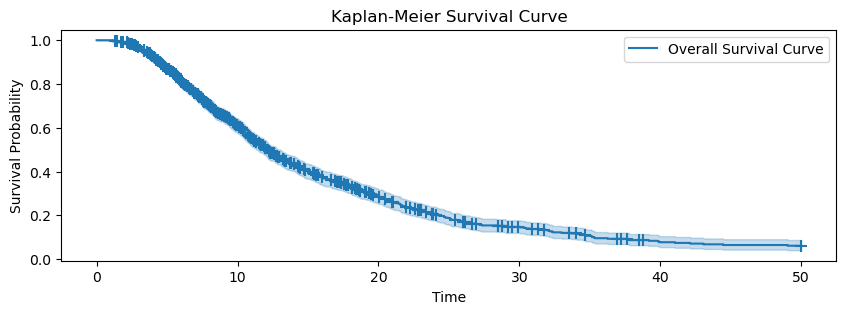


Data shape: (1000, 13)
Number of events: 689
Censoring rate: 0.31100000000000005


In [3]:
def generate_data(n_samples=1000, n_features=10, n_informative=3, 
                 shape=5, scale=10.0, censoring=0.3, random_seed=42):
    """Generate synthetic survival data with log-logistic distribution."""
    np.random.seed(random_seed)
    
    survival_data, true_coefficients = generate_survival_data_LL(
        n_samples, n_features, n_informative,
        shape, scale, censoring
    )
    feature_cols = [col for col in survival_data.columns if col.startswith('feature_')]
    
    return survival_data, true_coefficients, feature_cols

# Generate the data
survival_data, true_coefficients, feature_cols = generate_data()

# Plot initial KM curve for the entire dataset
plot_KM(survival_data)

print("\nData shape:", survival_data.shape)
print("Number of events:", survival_data['event_observed'].sum())
print("Censoring rate:", 1 - survival_data['event_observed'].mean())

## 1. Simple loghazard model

In [49]:
# Define the LogHazard model
class LogHazardModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.network(x)

# Prepare data for PyTorch
X = torch.FloatTensor(survival_data[feature_cols].values)
times = torch.FloatTensor(survival_data['observed_time'].values)
events = torch.FloatTensor(survival_data['event_observed'].values)

# Create data loader
dataset = TensorDataset(X, times, events)
batch_size = 64
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = LogHazardModel(len(feature_cols))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

C:\Users\ericf\Github\torchsurv\src\torchsurv\loss\cox.py:138: UserWarning: Ties in event time detected; using efron's method to handle ties.
  warnings.warn(


Epoch 10/50, Loss: 2.7248
Epoch 20/50, Loss: 2.6890
Epoch 30/50, Loss: 2.6514
Epoch 40/50, Loss: 2.6433
Epoch 50/50, Loss: 2.6245


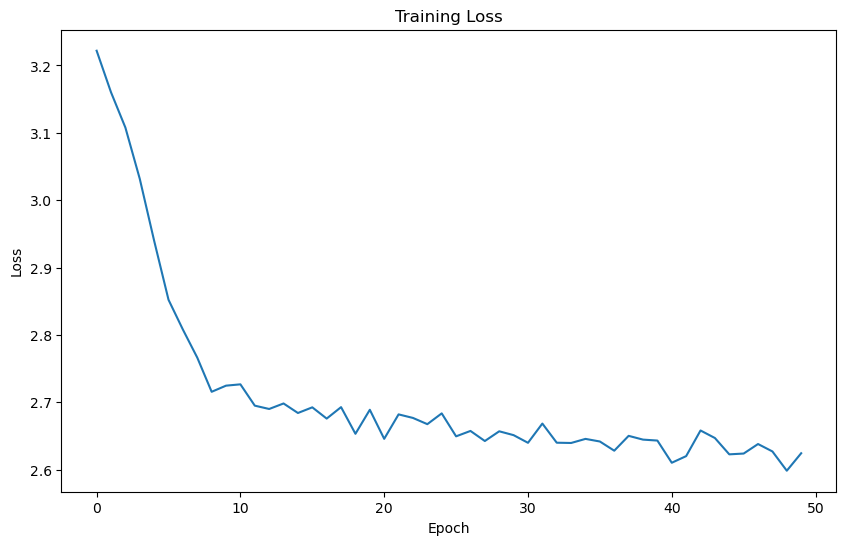

In [52]:
# Training loop
def train_epoch(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    
    for X_batch, times_batch, events_batch in train_loader:
        optimizer.zero_grad()
        
        # Get log hazards
        log_hazards = model(X_batch)
        
        # Calculate loss
        loss = tscox.neg_partial_log_likelihood(log_hazards, events_batch==1, times_batch, ties_method='efron', reduction = reduction)
        
        # # Basic implementation of cox partial likelihood
        # log_risk = log_hazards
        # risk = torch.exp(log_risk)
        
        # # Sort by time
        # sorted_times, sort_idx = torch.sort(times_batch, descending=True)
        # risk = risk[sort_idx]
        # events = events_batch[sort_idx]
        
        # # Calculate loss using cox partial likelihood
        # log_cumsum = torch.log(torch.cumsum(risk, dim=0) + 1e-8)
        # loss = -torch.mean((log_risk[events == 1] - log_cumsum[events == 1]))
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

# Train the model
n_epochs = 50
losses = []

for epoch in range(n_epochs):
    loss = train_epoch(model, train_loader, optimizer)
    losses.append(loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss:.4f}')

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Lowest Risk (Q1) size: 200
Q2 size: 200
Q3 size: 200
Q4 size: 200
Highest Risk (Q5) size: 200


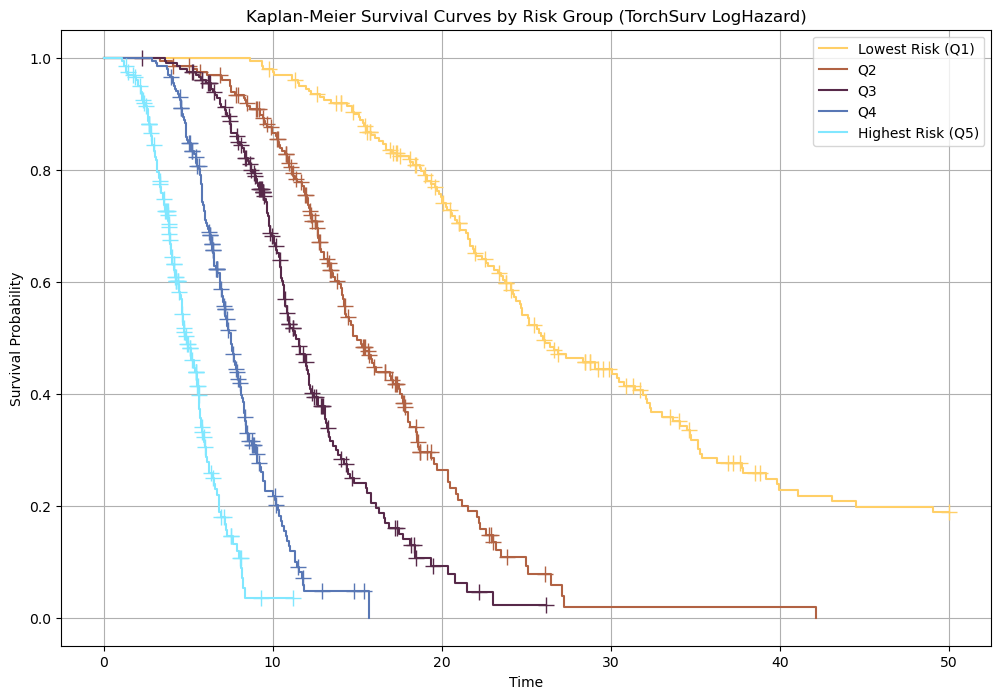

In [53]:
def stratify_and_plot(survival_data, risk_scores, n_groups=4):
    """Stratify patients into multiple risk groups and plot KM curves."""
    survival_data = survival_data.copy()
    survival_data['predicted_risk'] = risk_scores
    
    # Calculate quantile cutoffs
    quantiles = np.linspace(0, 1, n_groups + 1)
    cutoffs = np.quantile(survival_data['predicted_risk'], quantiles)
    
    # Plot KM curves
    plt.figure(figsize=(12, 8))
    
    # Create color map for groups
    colors = plt.cm.managua(np.linspace(0, 1, n_groups))
    
    for i in range(n_groups):
        if i == 0:
            mask = survival_data['predicted_risk'] <= cutoffs[1]
            group_label = f'Lowest Risk (Q1)'
        elif i == n_groups - 1:
            mask = survival_data['predicted_risk'] > cutoffs[-2]
            group_label = f'Highest Risk (Q{n_groups})'
        else:
            mask = (survival_data['predicted_risk'] > cutoffs[i]) & \
                   (survival_data['predicted_risk'] <= cutoffs[i+1])
            group_label = f'Q{i+1}'
        
        group = survival_data[mask]
        
        kmf = KaplanMeierFitter()
        kmf.fit(durations=group['observed_time'],
                event_observed=group['event_observed'],
                label=group_label)
        kmf.plot_survival_function(show_censors=True, ci_show=False, color=colors[i])
        
        print(f"{group_label} size: {len(group)}")
    
    plt.title('Kaplan-Meier Survival Curves by Risk Group (TorchSurv LogHazard)')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return cutoffs

# Generate risk scores using the trained model
model.eval()
with torch.no_grad():
    risk_scores = model(X).numpy().flatten()

# Create stratification plot
cutoffs = stratify_and_plot(survival_data, risk_scores, n_groups=5)

## 2. Ukko model

## 2. Ukko Model

Now we'll train a DualAttentionRegressor model from the ukko package and compare its performance.

C:\Users\ericf\Github\torchsurv\src\torchsurv\loss\cox.py:138: UserWarning: Ties in event time detected; using efron's method to handle ties.
  warnings.warn(


Epoch 3/40, Loss: 3.1640, Best Loss: 3.1630
Epoch 6/40, Loss: 2.9690, Best Loss: 2.9690
Epoch 9/40, Loss: 2.9791, Best Loss: 2.9111
Epoch 12/40, Loss: 2.8551, Best Loss: 2.8251
Epoch 15/40, Loss: 2.7845, Best Loss: 2.7845
Epoch 18/40, Loss: 2.7647, Best Loss: 2.7647
Epoch 21/40, Loss: 2.7282, Best Loss: 2.7269
Epoch 24/40, Loss: 2.7411, Best Loss: 2.7267
Epoch 27/40, Loss: 2.7241, Best Loss: 2.7241
Epoch 30/40, Loss: 2.7087, Best Loss: 2.7087
Epoch 33/40, Loss: 2.7064, Best Loss: 2.7064
Epoch 36/40, Loss: 2.7229, Best Loss: 2.7064
Epoch 39/40, Loss: 2.7412, Best Loss: 2.7059


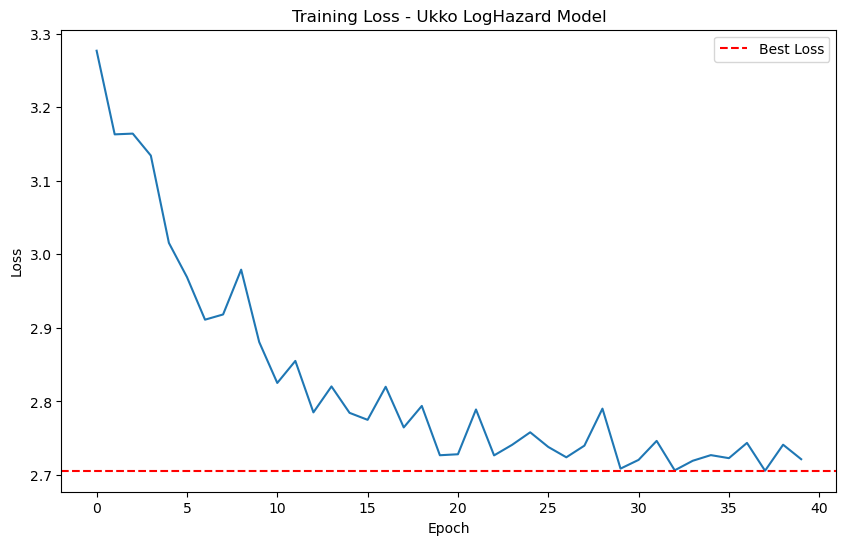


Loading best model with loss: 2.705862373113632


<All keys matched successfully>

In [56]:
from ukko.core import DualAttentionRegressor1
import copy 


# Define the Ukko LogHazard model
class UkkoLogHazardModel(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.attention_net = DualAttentionRegressor1(
            n_features=n_features,
            time_steps=1,  # Since we're using instantaneous inputs
            d_model=128,
            n_heads=4,
            dropout=0.1,
            n_modules=2
        )
    
    def forward(self, x):
        # Add time dimension expected by DualAttentionRegressor
        x = x.unsqueeze(2)  # [batch_size, n_features, 1]
        
        # Get predictions from attention network
        predictions, feat_weights, time_weights = self.attention_net(x)
        
        return predictions, feat_weights, time_weights

# Initialize model and optimizer
model = UkkoLogHazardModel(len(feature_cols))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 40  # Increased epochs since we're tracking best model
losses = []
best_loss = float('inf')
best_model_state = None

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    
    for X_batch, times_batch, events_batch in train_loader:
        optimizer.zero_grad()
        
        # Get log hazards
        log_hazards, feat_weights, time_weights = model(X_batch)
        
        # Calculate loss using TorchSurv's Cox partial likelihood
        loss = tscox.neg_partial_log_likelihood(log_hazards, events_batch==1, times_batch, ties_method='efron', reduction='mean')
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    
    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = copy.deepcopy(model.state_dict())
    
    if (epoch + 1) % 3 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}, Best Loss: {best_loss:.4f}')

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.axhline(y=best_loss, color='r', linestyle='--', label='Best Loss')
plt.title('Training Loss - Ukko LogHazard Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Load best model for evaluation
print('\nLoading best model with loss:', best_loss)
model.load_state_dict(best_model_state)

Lowest Risk (Q1) size: 200
Q2 size: 200
Q3 size: 200
Q4 size: 200
Highest Risk (Q5) size: 200


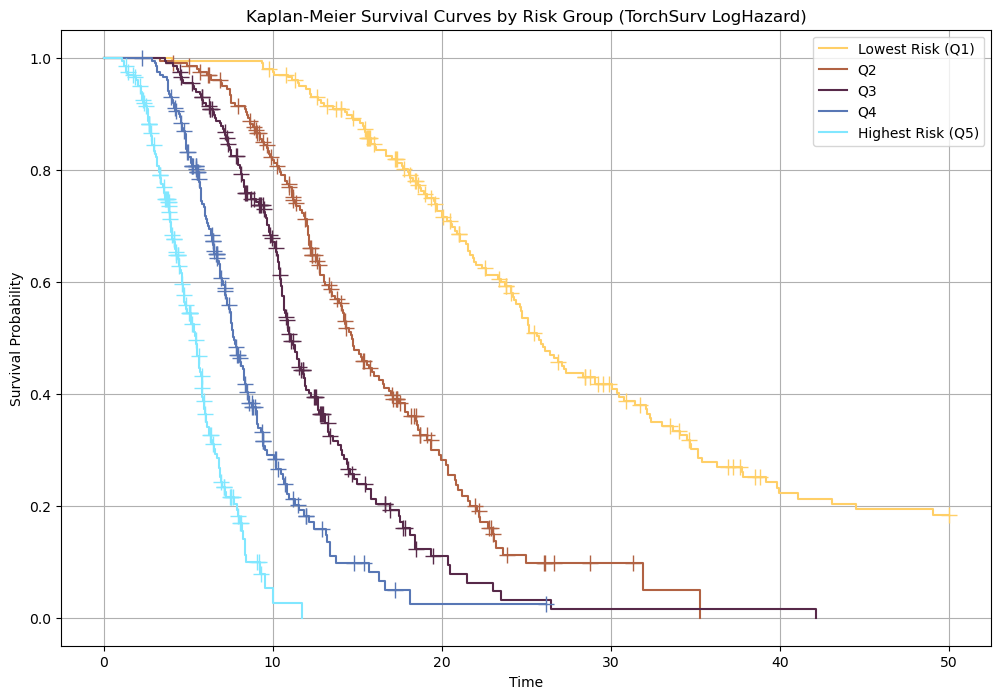

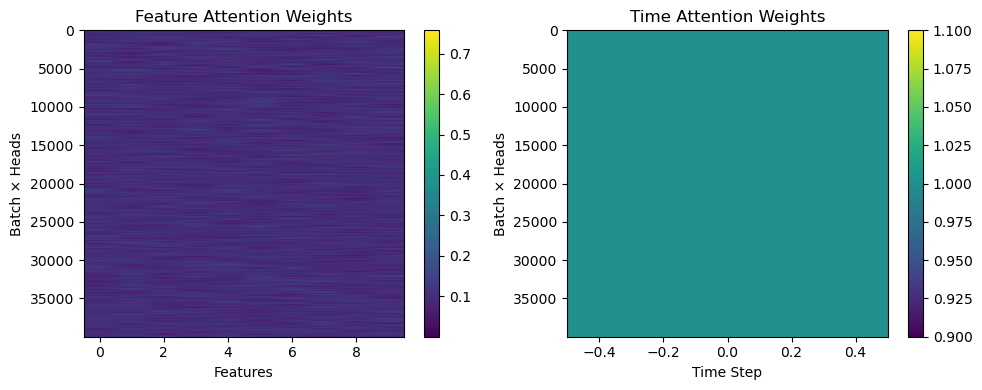

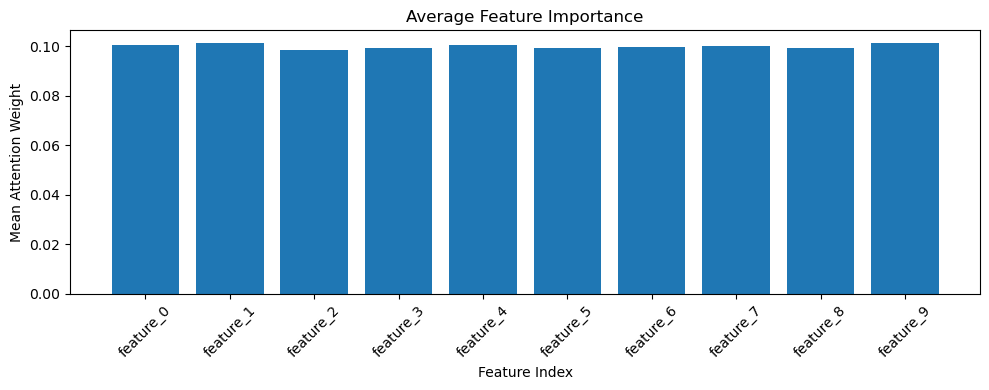

In [57]:
# Generate risk scores using the trained model
model.eval()
with torch.no_grad():
    risk_scores, feat_weights, time_weights = model(X)
    risk_scores = risk_scores.numpy()

# Create stratification plot
cutoffs = stratify_and_plot(survival_data, risk_scores, n_groups=5)

# Visualize attention weights
plt.figure(figsize=(10, 4))

# Feature attention weights - reshape for visualization
feat_attention = feat_weights.detach().numpy()
feat_attention = feat_attention.reshape(-1, len(feature_cols))  # Reshape to [batch*heads, n_features]

plt.subplot(121)
plt.imshow(feat_attention, aspect='auto')
plt.title('Feature Attention Weights')
plt.colorbar()
plt.xlabel('Features')
plt.ylabel('Batch × Heads')

# Time attention weights - should be 1×1 for our case
plt.subplot(122)
time_attention = time_weights.detach().numpy()
time_attention = time_attention.reshape(-1, 1)  # Reshape to [batch*heads, 1]

plt.imshow(time_attention, aspect='auto')
plt.title('Time Attention Weights')
plt.colorbar()
plt.xlabel('Time Step')
plt.ylabel('Batch × Heads')

plt.tight_layout()
plt.show()

# Print average feature attention weights
mean_attention = feat_attention.mean(axis=0)
plt.figure(figsize=(10, 4))
plt.bar(range(len(feature_cols)), mean_attention)
plt.title('Average Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('Mean Attention Weight')
plt.xticks(range(len(feature_cols)), feature_cols, rotation=45)
plt.tight_layout()
plt.show()